<h1>ANSWERS TO EDA QUESTIONS</h1>

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#load datasets
flight_df = pd.read_csv("C:/Users/hp/Downloads/Flight Level Data.csv")
bag_df = pd.read_csv("C:/Users/hp/Downloads/Bag+Level+Data.csv")
pnr_flight_df = pd.read_csv("C:/Users/hp/Downloads/PNR+Flight+Level+Data.csv")
pnr_remark_df = pd.read_csv("C:/Users/hp/Downloads/PNR Remark Level Data.csv")
airport_df = pd.read_csv("C:/Users/hp/Downloads/Airports Data.csv")

Creating a combined dataset

In [4]:
#Creating a unique flight identifier key(Flight_key)
#joining data across different files (Flight, PNR Flight).

def create_flight_key(df):
    return df['company_id'].astype(str) + '_' + \
           df['flight_number'].astype(str) + '_' + \
           df['scheduled_departure_date_local'].astype(str) + '_' + \
           df['scheduled_departure_station_code'].astype(str) + '_' + \
           df['scheduled_arrival_station_code'].astype(str)

In [5]:
# Add flight_key to flight_df and pnr_flight_df datasets
flight_df['flight_key'] = create_flight_key(flight_df)
pnr_flight_df['flight_key'] = create_flight_key(pnr_flight_df)

<h2>Q1. Average delay and percentage of flights departing later than scheduled</h2>

In [6]:
flight_df['scheduled_departure_datetime_local'] = pd.to_datetime(flight_df['scheduled_departure_datetime_local'], utc=True)
flight_df['actual_departure_datetime_local'] = pd.to_datetime(flight_df['actual_departure_datetime_local'], utc=True)

flight_df['departure_delay_minutes'] = (
    flight_df['actual_departure_datetime_local'] - flight_df['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

In [8]:
average_delay = flight_df['departure_delay_minutes'].mean()
late_departures = flight_df[flight_df['departure_delay_minutes'] > 0]
percent_late = (len(late_departures) / len(flight_df)) * 100
print(percent_late)

49.611063094209165


In [10]:
q1_results = {
    'average_delay_minutes': average_delay,
    'percentage_flights_late': percent_late
}
print(q1_results)

{'average_delay_minutes': np.float64(21.18496110630942), 'percentage_flights_late': 49.611063094209165}


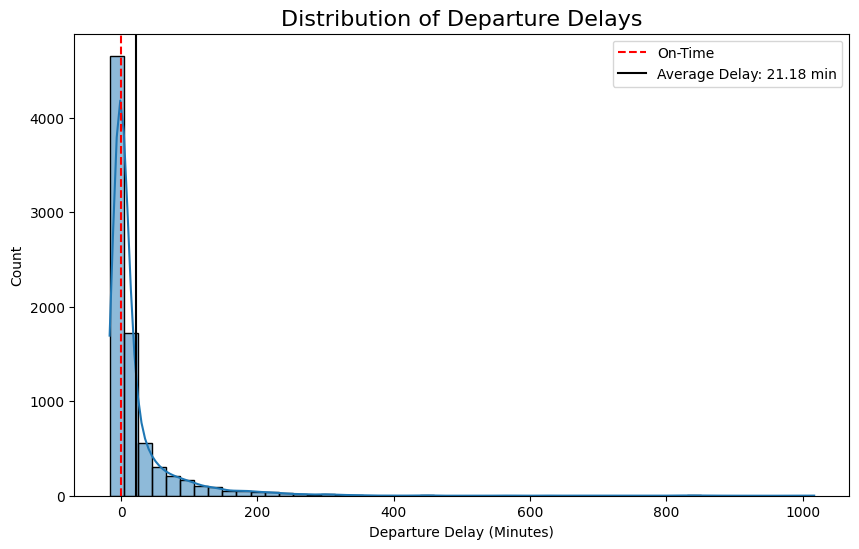

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(flight_df['departure_delay_minutes'], bins=50, kde=True)
plt.title('Distribution of Departure Delays', fontsize=16)
plt.xlabel('Departure Delay (Minutes)')
plt.axvline(0, color='red', linestyle='--', label='On-Time')
plt.axvline(average_delay, color='black', linestyle='-', label=f'Average Delay: {average_delay:.2f} min')
plt.legend()
plt.show()

<h2>Q2. Flights with scheduled ground time close to or below minimum turn mins</h2>

In [12]:
flight_df['ground_time_pressure'] = flight_df['scheduled_ground_time_minutes'] - flight_df['minimum_turn_minutes']
tight_turn_flights = flight_df[flight_df['ground_time_pressure'] <= 0]
count_tight_turn = len(tight_turn_flights)

q2_results = {
    'flights_tight_turn_count': count_tight_turn
}
print(q2_results)

{'flights_tight_turn_count': 652}


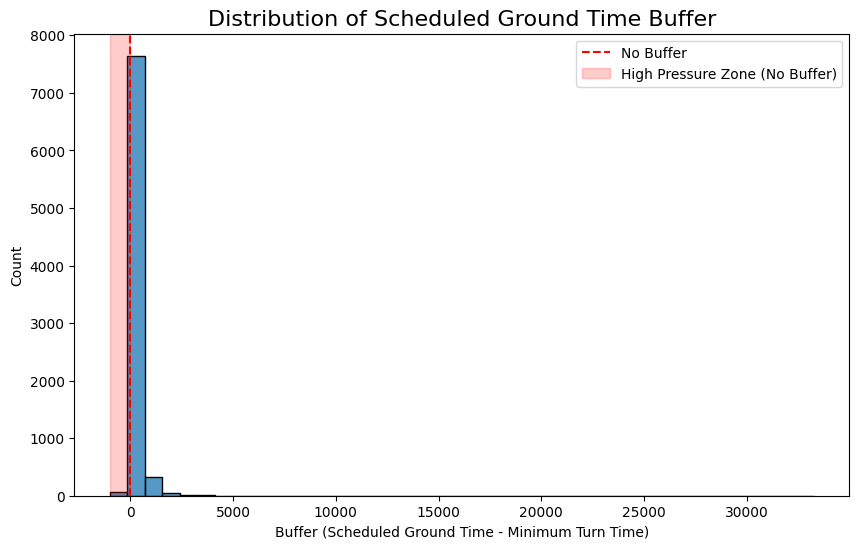

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(flight_df['ground_time_pressure'], bins=40)
plt.title('Distribution of Scheduled Ground Time Buffer', fontsize=16)
plt.xlabel('Buffer (Scheduled Ground Time - Minimum Turn Time)')
plt.axvline(0, color='red', linestyle='--', label='No Buffer')
plt.axvspan(flight_df['ground_time_pressure'].min(), 0, color='red', alpha=0.2, label='High Pressure Zone (No Buffer)')
plt.legend()
plt.show()

<h2>Q3. Average ratio of transfer bags vs. checked bags across flights</h2>

In [31]:
# Add this line to debug
print("Unique values in bag_type column:")
print(bag_df['bag_type'].value_counts())

Unique values in bag_type column:
bag_type
Transfer        347546
Origin          290121
Hot Transfer     49578
Name: count, dtype: int64


In [32]:
#concatenating multiple columns into single identifier string. counts how many bags of each type are present for each flight.
bag_df['flight_key_short'] = bag_df['company_id'].astype(str) + '_' + \
                             bag_df['flight_number'].astype(str) + '_' + \
                             bag_df['scheduled_departure_date_local'].astype(str) + '_' + \
                             bag_df['scheduled_departure_station_code'].astype(str)

bag_counts = bag_df.groupby('flight_key_short')['bag_type'].value_counts().unstack(fill_value=0).reset_index()

In [35]:
#ratio: Transfer / Origin. Use np.nan if Origin bags are zero.
bag_counts['transfer_to_origin_ratio'] = np.where(
    bag_counts['Origin'] > 0,
    bag_counts['Transfer'] / bag_counts['Origin'],
    np.nan
)
# Calculate the mean of the new ratio column
average_bag_ratio = bag_counts['transfer_to_origin_ratio'].mean()

q3_results = {
    'average_transfer_to_checked_ratio': average_bag_ratio
}
print(q3_results)

{'average_transfer_to_checked_ratio': np.float64(3.221325690372997)}


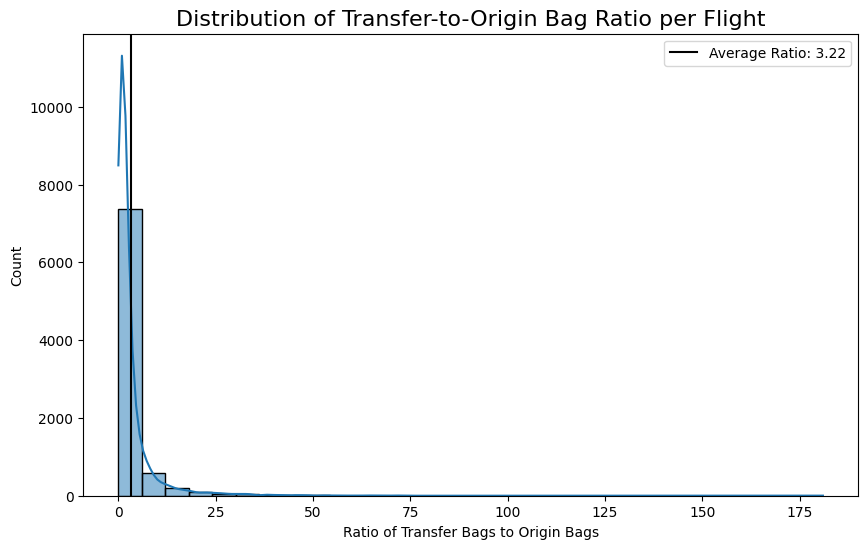

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(bag_counts['transfer_to_origin_ratio'].dropna(), bins=30, kde=True)
plt.title('Distribution of Transfer-to-Origin Bag Ratio per Flight', fontsize=16)
plt.xlabel('Ratio of Transfer Bags to Origin Bags')
plt.axvline(average_bag_ratio, color='black', linestyle='-', label=f'Average Ratio: {average_bag_ratio:.2f}')
plt.legend()
plt.show()

FOR Q4 & Q5: Merge Pax, Load Factor, and Delay

In [37]:
pnr_flight_grouped = pnr_flight_df.groupby(['flight_key', 'record_locator'])['total_pax'].max().reset_index()
total_pax_per_flight = pnr_flight_grouped.groupby('flight_key')['total_pax'].sum().reset_index(name='total_passengers')
combined_analysis_df = flight_df[['flight_key', 'departure_delay_minutes', 'total_seats']].merge(
    total_pax_per_flight, on='flight_key', how='left'
)
combined_analysis_df['total_passengers'] = combined_analysis_df['total_passengers'].fillna(0)
combined_analysis_df['load_factor'] = combined_analysis_df['total_passengers'] / combined_analysis_df['total_seats']
combined_analysis_df.loc[combined_analysis_df['total_seats'] == 0, 'load_factor'] = np.nan
combined_analysis_df['load_factor'] = combined_analysis_df['load_factor'].replace([np.inf, -np.inf], np.nan)

<h2>Q4. Passenger loads comparison and correlation with operational difficulty</h2>

In [39]:
load_stats = combined_analysis_df['load_factor'].describe()
corr_df = combined_analysis_df.dropna(subset=['load_factor', 'departure_delay_minutes'])
load_delay_correlation, _ = pearsonr(corr_df['load_factor'], corr_df['departure_delay_minutes'])

q4_results = {
    'load_factor_stats': load_stats.to_dict(),
    'load_delay_correlation': load_delay_correlation
}
print(q4_results)

{'load_factor_stats': {'count': 8099.0, 'mean': 0.8871042849999129, 'std': 0.14991516963948376, 'min': 0.06, '25%': 0.8493975903614458, '50%': 0.94, '75%': 0.9879518072289156, 'max': 1.0263157894736843}, 'load_delay_correlation': np.float64(-0.1762923771446781)}


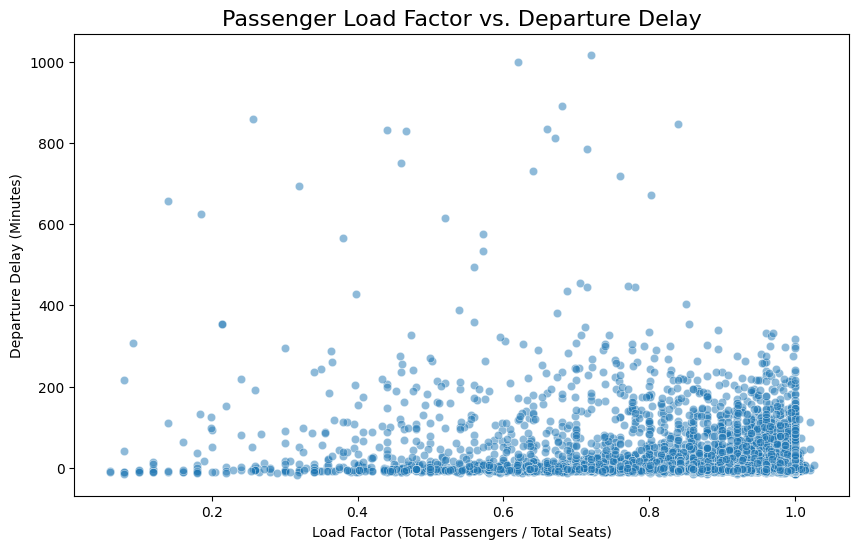

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='load_factor', y='departure_delay_minutes', data=corr_df, alpha=0.5)
plt.title('Passenger Load Factor vs. Departure Delay', fontsize=16)
plt.xlabel('Load Factor (Total Passengers / Total Seats)')
plt.ylabel('Departure Delay (Minutes)')
plt.show()

<h2>High special service requests (SSR) and delay, controlling for load</h2>

In [41]:
ssr_count_per_pnr = pnr_remark_df.groupby('record_locator')['special_service_request'].count().reset_index(name='ssr_count_pnr')
pnr_flight_ssr_merged = pnr_flight_df[['flight_key', 'record_locator']].merge(
    ssr_count_per_pnr, on='record_locator', how='left'
)
pnr_flight_ssr_merged['ssr_count_pnr'] = pnr_flight_ssr_merged['ssr_count_pnr'].fillna(0)
ssr_count_per_flight = pnr_flight_ssr_merged.groupby('flight_key')['ssr_count_pnr'].sum().reset_index(name='total_ssr_count')
final_analysis_df = combined_analysis_df.merge(
    ssr_count_per_flight, on='flight_key', how='left'
)

In [42]:
final_analysis_df['total_ssr_count'] = final_analysis_df['total_ssr_count'].fillna(0)
analysis_cols = ['departure_delay_minutes', 'load_factor', 'total_ssr_count']
analysis_df_clean = final_analysis_df.dropna(subset=analysis_cols)

r_xy, _ = pearsonr(analysis_df_clean['total_ssr_count'], analysis_df_clean['departure_delay_minutes'])
r_xz, _ = pearsonr(analysis_df_clean['total_ssr_count'], analysis_df_clean['load_factor'])
r_yz, _ = pearsonr(analysis_df_clean['departure_delay_minutes'], analysis_df_clean['load_factor'])

denominator = np.sqrt((1 - r_xz**2) * (1 - r_yz**2))
partial_correlation = (r_xy - r_xz * r_yz) / denominator if denominator != 0 else np.nan

q5_results = {
    'ssr_delay_correlation_uncontrolled': r_xy,
    'ssr_delay_load_partial_correlation': partial_correlation
}

print(q5_results)

{'ssr_delay_correlation_uncontrolled': np.float64(0.04067347627936549), 'ssr_delay_load_partial_correlation': np.float64(0.06553202036279063)}


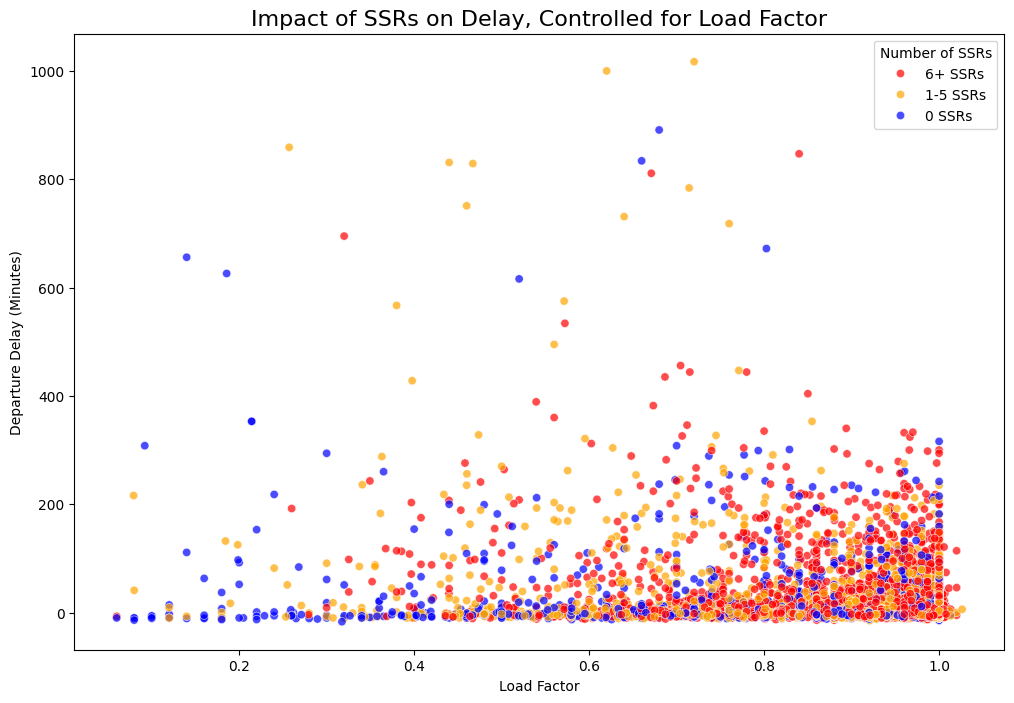

In [44]:
def ssr_category(count):
    if count == 0: return '0 SSRs'
    elif 1 <= count <= 5: return '1-5 SSRs'
    else: return '6+ SSRs'
analysis_df_clean['ssr_category'] = analysis_df_clean['total_ssr_count'].apply(ssr_category)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='load_factor',
    y='departure_delay_minutes',
    hue='ssr_category',
    data=analysis_df_clean,
    alpha=0.7,
    palette={'0 SSRs': 'blue', '1-5 SSRs': 'orange', '6+ SSRs': 'red'}
)
plt.title('Impact of SSRs on Delay, Controlled for Load Factor', fontsize=16)
plt.xlabel('Load Factor')
plt.ylabel('Departure Delay (Minutes)')
plt.legend(title='Number of SSRs')
plt.show()

<h2>EDA SUMMARY</h2>

In [ ]:
print("\n--- EDA Results Summary ---")
print("\n1. Average delay and percentage of flights departing later than scheduled:")
print(f"   Average Departure Delay: {q1_results['average_delay_minutes']:.2f} minutes")
print(f"   Percentage of Flights Departing Late: {q1_results['percentage_flights_late']:.2f}%")
print("\n2. Flights with scheduled ground time close to or below minimum turn mins:")
print(f"   Flights with Tight Turn Time: {q2_results['flights_tight_turn_count']}")
print("\n3. Average ratio of transfer bags vs. checked bags across flights:")
print(f"   Average Transfer to Checked Bag Ratio: {q3_results['average_transfer_to_checked_ratio']:.3f}")
print("\n4. Passenger loads comparison and correlation with operational difficulty (delay):")
print("   Load Factor Descriptive Statistics:")
for key, value in q4_results['load_factor_stats'].items():
     print(f"      {key.capitalize():<12}: {value:.3f}")
print(f"   Correlation (Load Factor vs. Delay): {q4_results['load_delay_correlation']:.4f}")
print("\n5. High special service requests flights also high-delay after controlling for load?")
print(f"   Correlation (SSR Count vs. Delay, Uncontrolled): {q5_results['ssr_delay_correlation_uncontrolled']:.4f}")
print(f"   Partial Correlation (SSR Count vs. Delay, controlled for Load): {q5_results['ssr_delay_load_partial_correlation']:.4f}")


--- EDA Results Summary ---

1. Average delay and percentage of flights departing later than scheduled:
   Average Departure Delay: 21.18 minutes
   Percentage of Flights Departing Late: 49.61%

2. Flights with scheduled ground time close to or below minimum turn mins:
   Flights with Tight Turn Time: 652

3. Average ratio of transfer bags vs. checked bags across flights:
   Average Transfer to Checked Bag Ratio: 3.361

4. Passenger loads comparison and correlation with operational difficulty (delay):
   Load Factor Descriptive Statistics:
     Count       : 8099.000
     Mean        : 0.364
     Std         : 0.088
     Min         : 0.000
     25%         : 0.316
     50%         : 0.373
     75%         : 0.420
     Max         : 0.665
   Correlation (Load Factor vs. Delay): -0.1245

5. High special service requests flights also high-delay after controlling for load?
   Correlation (SSR Count vs. Delay, Uncontrolled): 0.0234
   Partial Correlation (SSR Count vs. Delay, controlled f